# Import librairies

In [1]:
# import standard librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import datetime
import os
from tqdm.notebook import tqdm
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import brute
import time
import random

from copy import deepcopy

from src.utils.simparam import SimParam
from src.simfunc.simulation import Simulation


%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2


# Rule definition

In [2]:
# convenience functions for plotting
def minutes_to_hms(minutes):
    if np.isnan(minutes):
        hms = np.nan
    else:
        hms = "{0:s} {1:0=2d}:{2:0=2d}:{3:0=2d}".format(
            "2020-10-13",
            int((minutes % 1440) // 60),
            int(minutes % 60),
            int((minutes % 1) * 60),
        )
    return hms


# # timing function for graphs
# def counter_timing_func(
#     t: float,
#     start_time: float = 2.5,
#     onecounter_time: float = 0.75,
#     base_n_counter: int = 4,
#     **unused,
# ):
#     y = 0
#     if onecounter_time < t <= start_time:
#         y = base_n_counter
#     if 0 < t <= onecounter_time:
#         y = 1
#     return y


# counter = f(seats) for graphs
def counter_hour_number_func(
    seats: int,
    start_time: float = 2.5,
    onecounter_time: float = 0.75,
    base_n_counter: int = 4,
    seats_per_add_counter: int = 60,
):
    counter = max(
        base_n_counter,
        base_n_counter + 1 + ((seats - 201) // seats_per_add_counter),
    )

    y = counter * (start_time - onecounter_time) + 1 * onecounter_time

    y = y*3600

    z = y / seats

    return z

In [3]:
def new_rule_counters(
        seats:int,
        base_n_counter: int = 2,
        seats_per_add_counter: int = 120,
        ):
    
    counters = base_n_counter
    x = base_n_counter
    y = base_n_counter

    if seats>200:
        extra_seats = seats - 200
        n = extra_seats//60 +1
        if n%2 ==1:
            y += n//2+1
            x += n//2
        else:
            x += n//2
            y += n//2

    return (8100*x+4800*y + 2700 )/seats

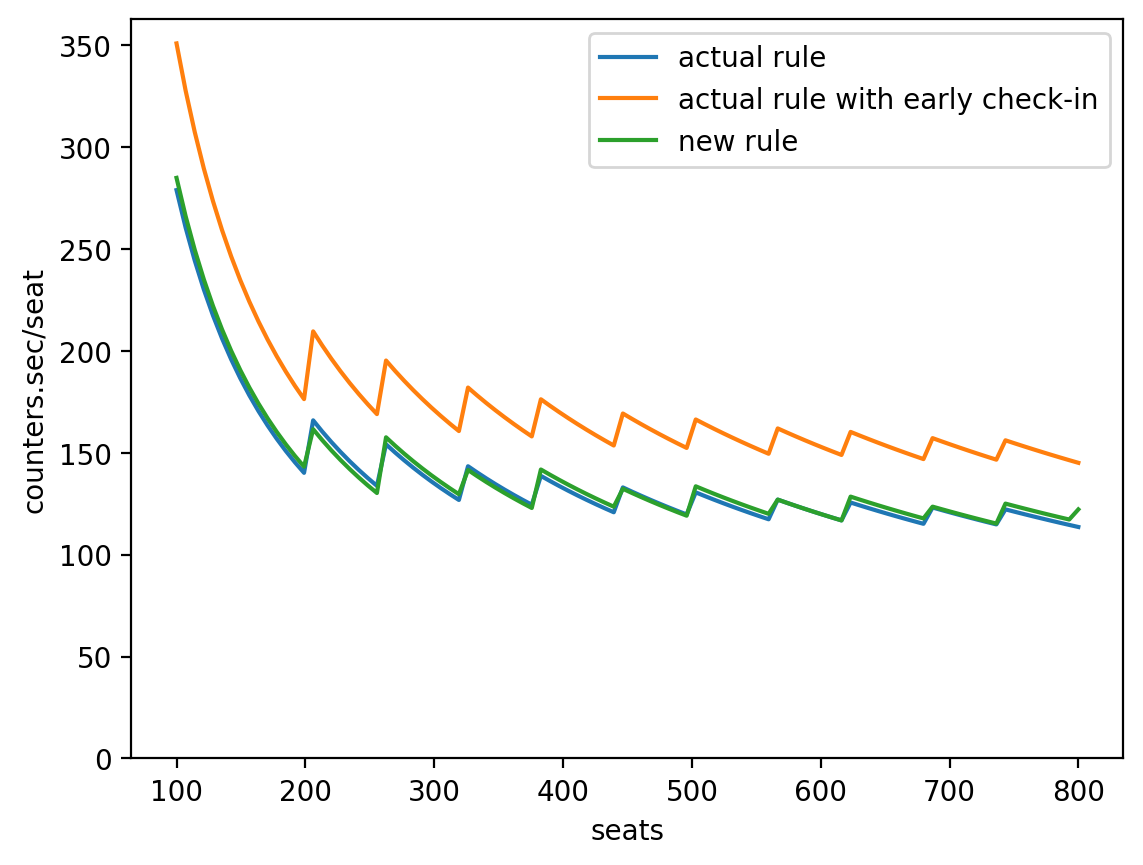

In [4]:
fig,ax = plt.subplots()
x = np.linspace(100, 800, num=100)
ax.plot(x,[counter_hour_number_func(i) for i in x],label="actual rule")
ax.plot(x,[counter_hour_number_func(i,start_time=3) for i in x],label="actual rule with early check-in")
ax.plot(x,[new_rule_counters(i,seats_per_add_counter=120) for i in x],label="new rule")
ax.set(ylabel="counters.sec/seat",xlabel='seats')
ax.set_ylim(bottom=0)
plt.legend()

# simulation

In [5]:
# get FY2019 data
data = pd.read_excel(
    io="/home/antoine/projects/pax-flow-sim/data/raw/FY2019_FY2025 merge.xlsx",
    header=0,
    sheet_name="IntlP_FY19-FY25",
)

# format the file from aero
mask2019 = (data["FY"] == "FY2019") & (data["Day Of Week"] == "Saturday") & (data['T1/T2(MM/9C/7C/TW)'] == 'T1')
data2019 = data[mask2019].reset_index().copy()
data2019["Sector"] = data2019["Int/Dom"]
data2019["Flight Date"] = pd.to_datetime("2019-10-13")
data2019["Scheduled Time"] = data2019["5min Interval"].apply(
    lambda x: f"{x // 100}:{x % 100}:00",
)
data2019["Category(P/C/O)"] = data2019["Category(P/C/O)"].apply(lambda x: x[0])


In [17]:

# create simparam2019
simparam2019 = SimParam()
simparam2019.schedule_from_df(data2019).schedule_cleanup().schedule_filter(
    date_str="2019-10-13"
)
simparam2019.show_up_from_file().assign_flight_show_up_category_default().assign_show_up()

# for simulation later
simparam2019.df_Pax["pax_type"] = "tradi"
simparam2019.dct_resource = {
    # "kiosk": 92,
}
simparam2019.dct_processes = {
    # "kiosk": 70,
    "checkin": 100,
}
simparam2019.dct_process_sequence = {
    "tradi": [
        # ["kiosk", "wait_opening", "checkin"],
        ["wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
}


# define plot name
simparam2019.plot_name = "FY19_new_rule"

simparam2019_current_rule = deepcopy(simparam2019)
simparam2019_early = deepcopy(simparam2019)
simparam2019_new_rule = deepcopy(simparam2019)
simparam2019_new_rule.plot_name = "FY19_new_rule"
simparam2019_current_rule.plot_name = "FY19_current_rule"
simparam2019_early.plot_name = "FY19_early_30min"


simparam2019_early.dct_process_sequence = {
    "tradi": [
        ["wait_opening", "checkin"],
        {"hour_to_std": 3},
    ],
}

simparam2019_new_rule.dct_process_sequence = {
    "tradi": [
        [ "wait_opening", "checkin"],
        {"hour_to_std": 3},
    ],
}



In [18]:
simparam2019_new_rule.assign_new_check_in()
simparam2019_current_rule.assign_check_in()
simparam2019_early.assign_check_in(start_time=3)

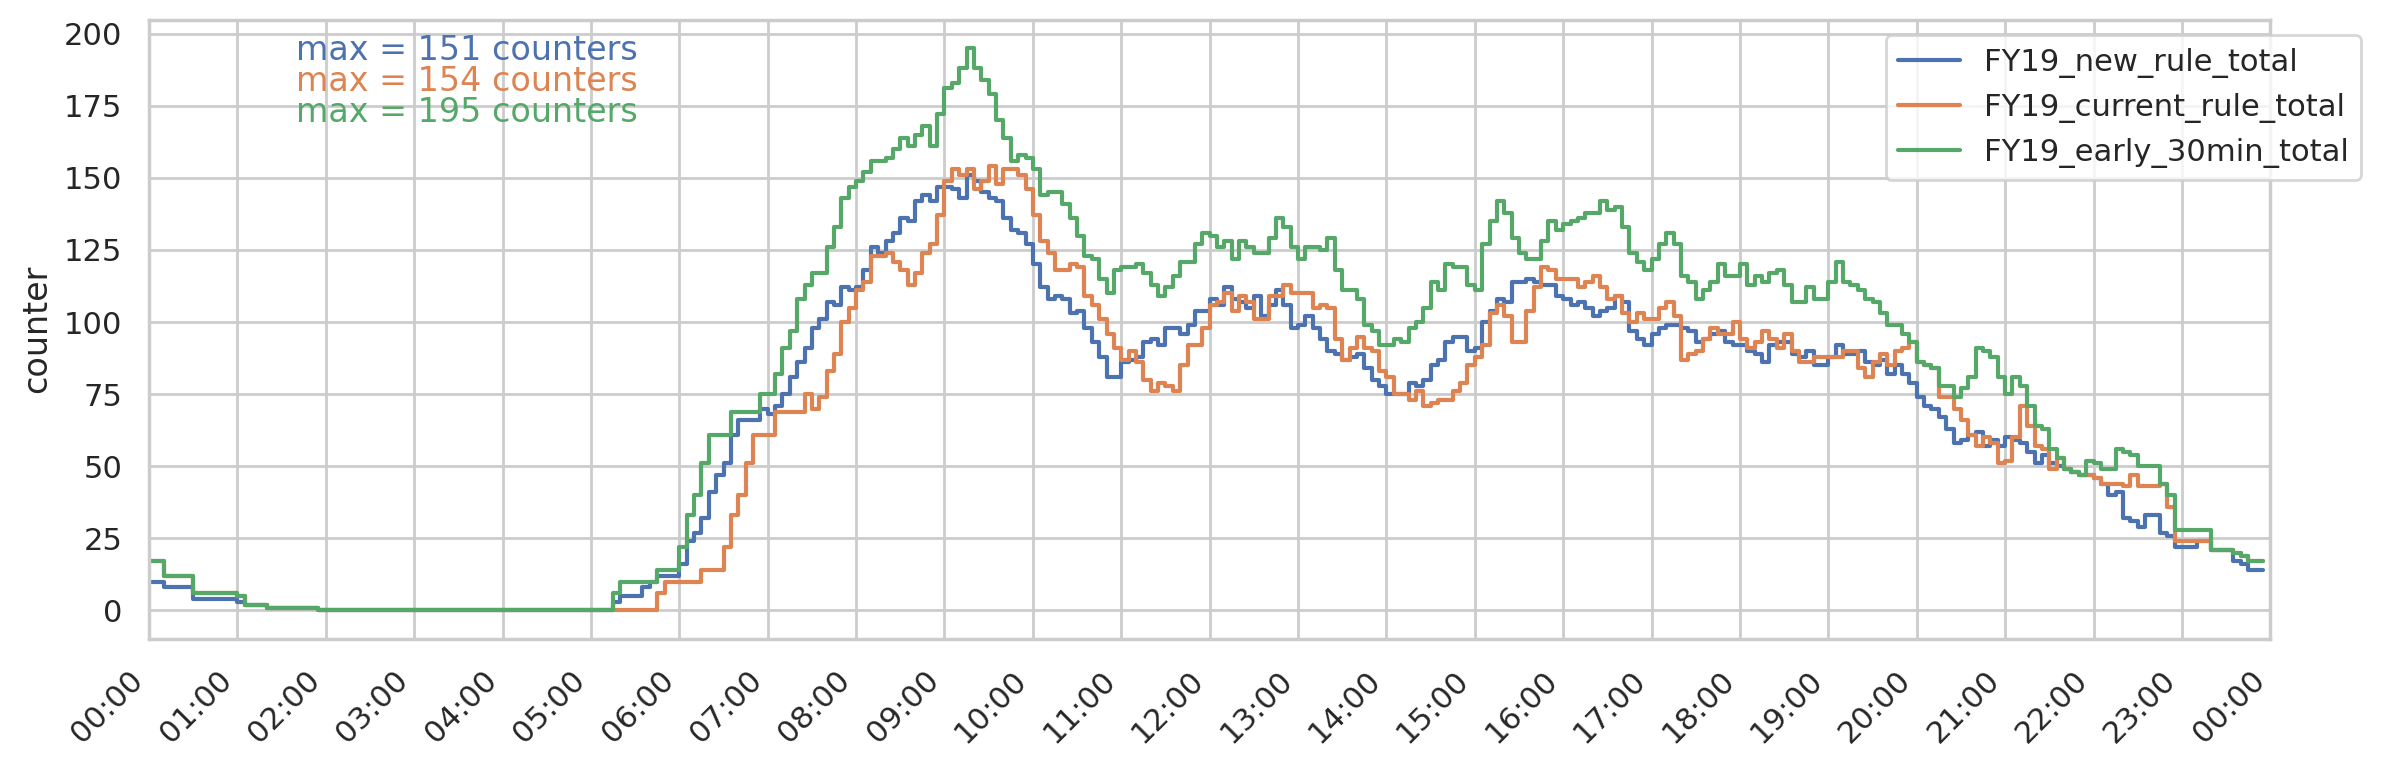

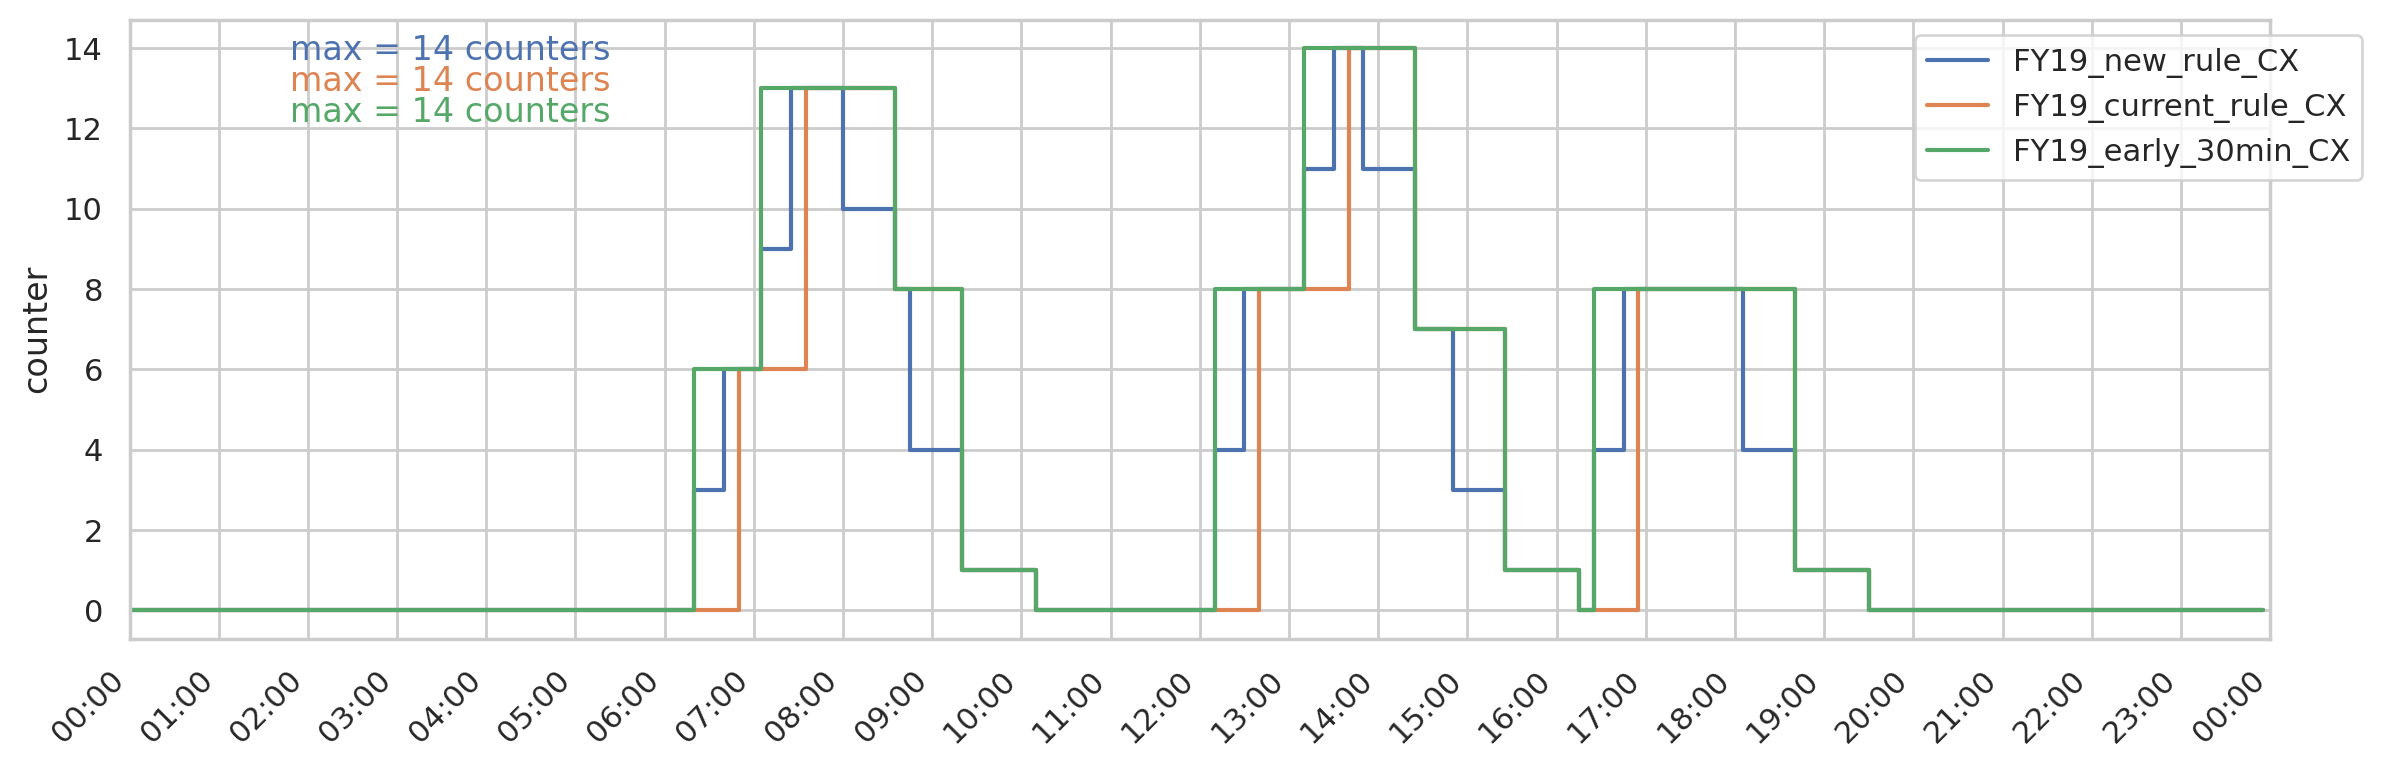

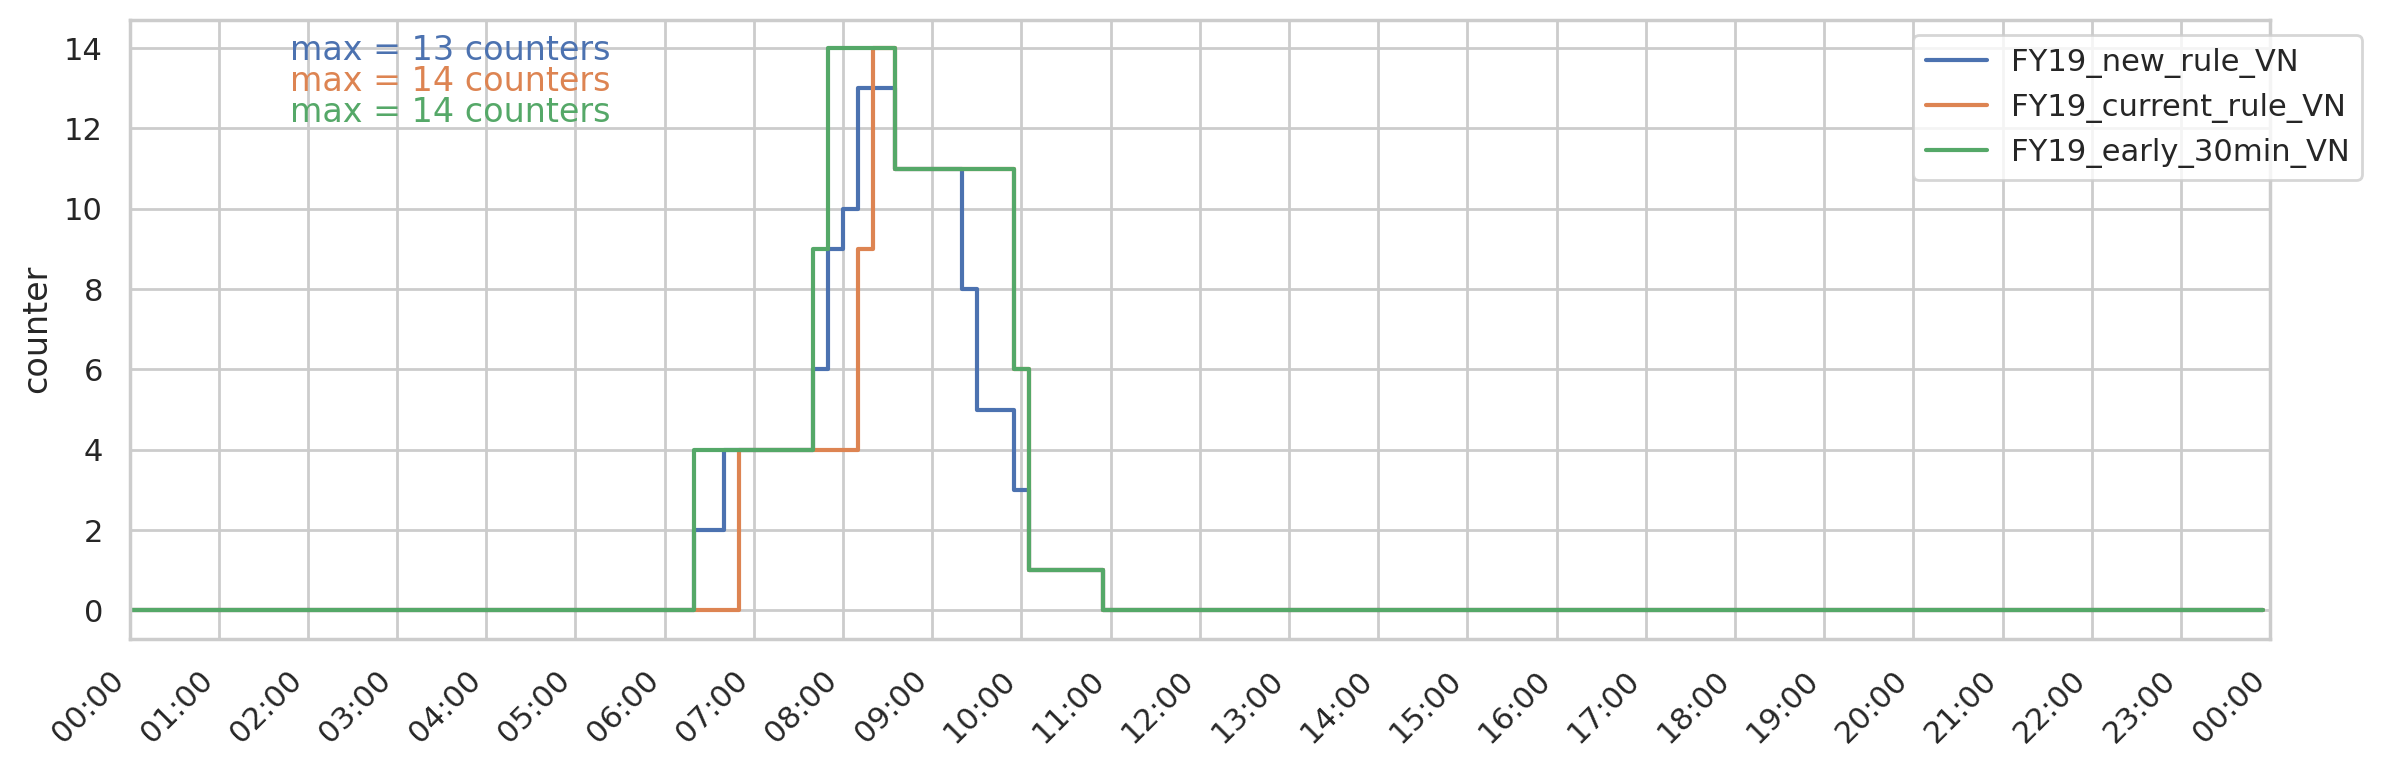

In [19]:
simparam2019_new_rule.plot_counters(compare_with=[simparam2019_current_rule,simparam2019_early])
simparam2019_new_rule.plot_counters(compare_with=[simparam2019_current_rule,simparam2019_early],airlines=["CX"])
simparam2019_new_rule.plot_counters(compare_with=[simparam2019_current_rule,simparam2019_early],airlines=["VN"])



In [20]:
simparams = [simparam2019_new_rule,simparam2019_current_rule,simparam2019_early]
simulations = {simparam.plot_name:Simulation(simparam) for simparam in simparams}

In [21]:
for key,simulation in simulations.items():
    simulation.generate_checkin().generate_pax().run()
    simulation.format_df_result()


Simulation running...: 100%|██████████| 1439/1439 [00:38<00:00, 37.54it/s] 


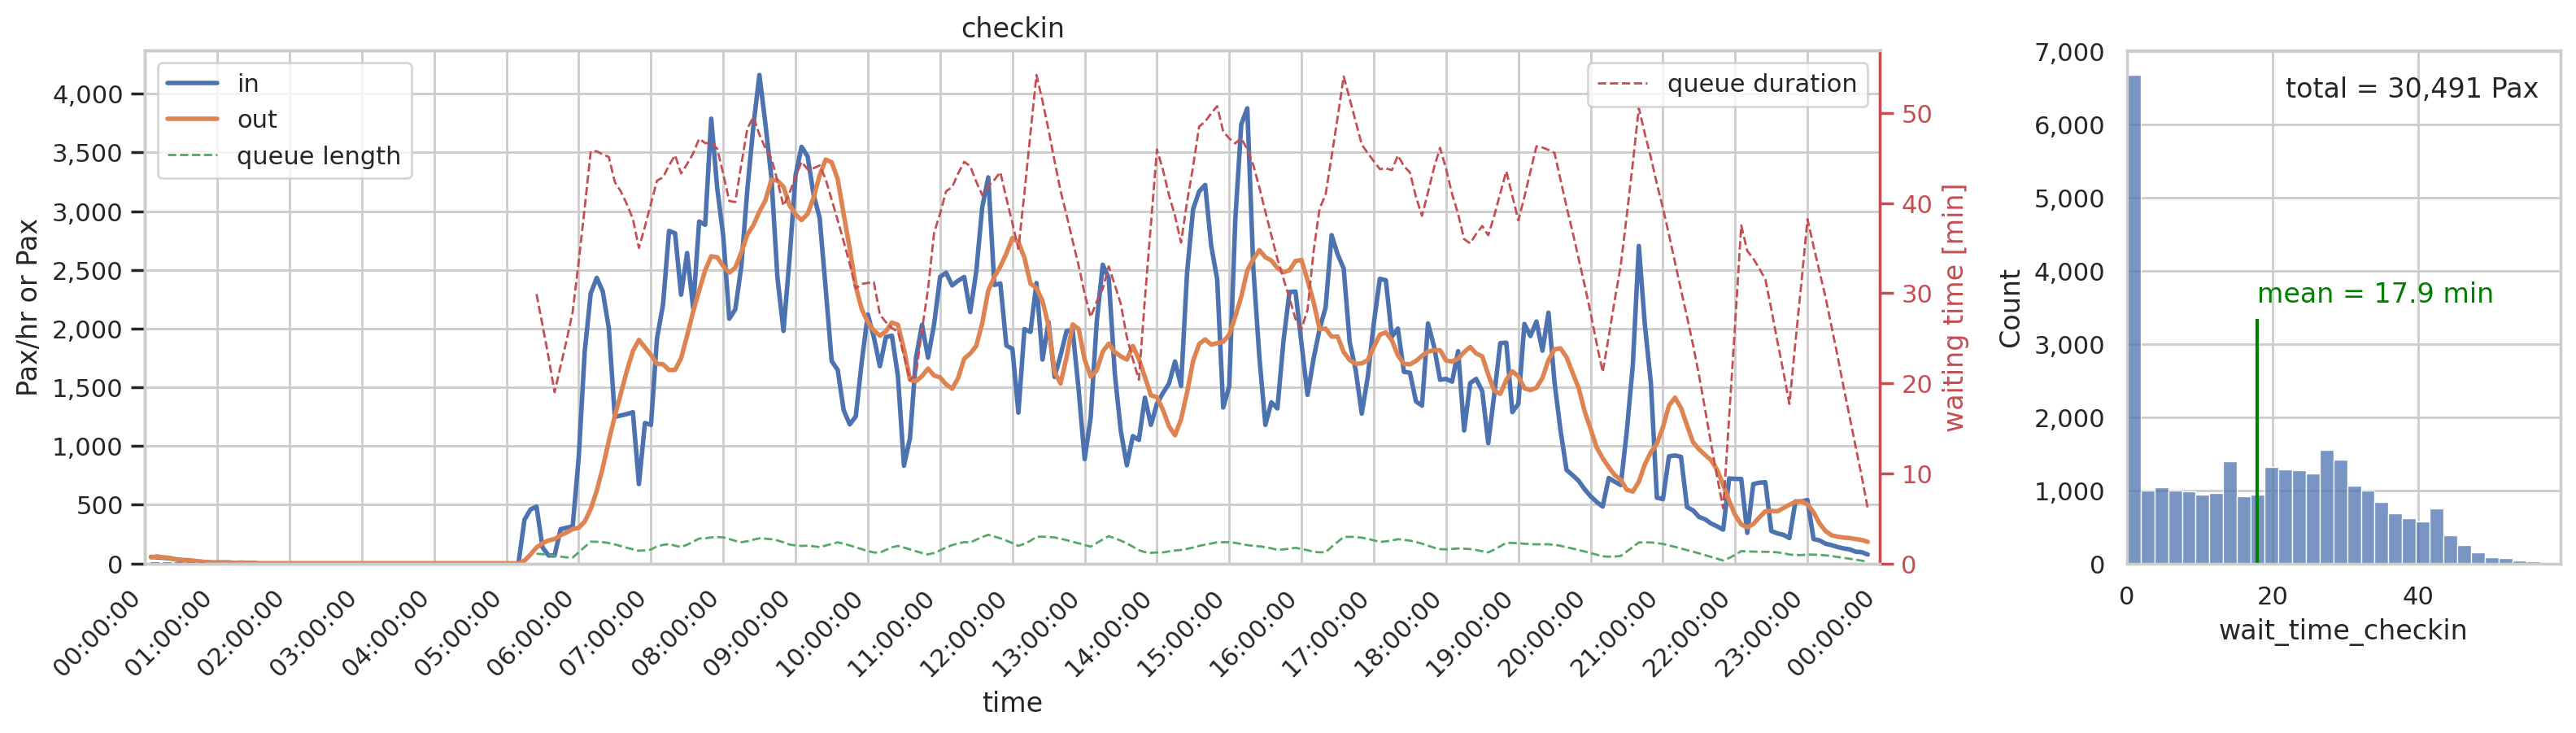

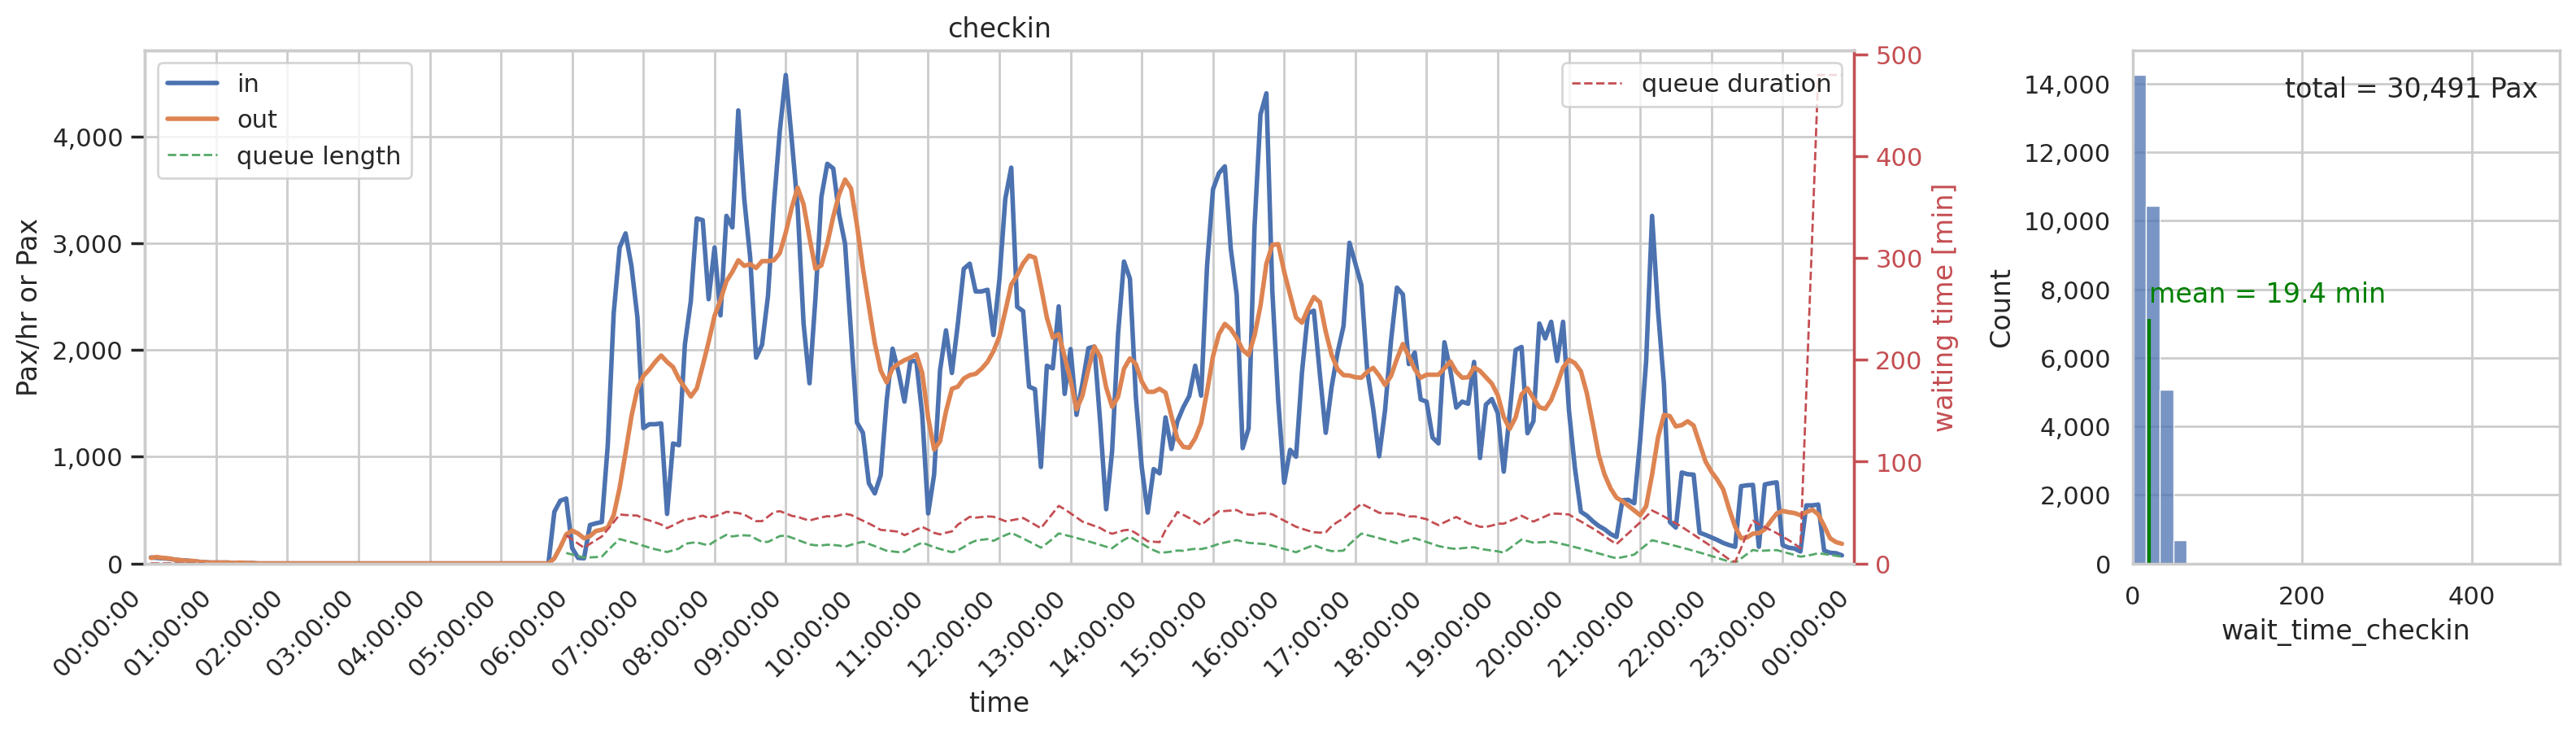

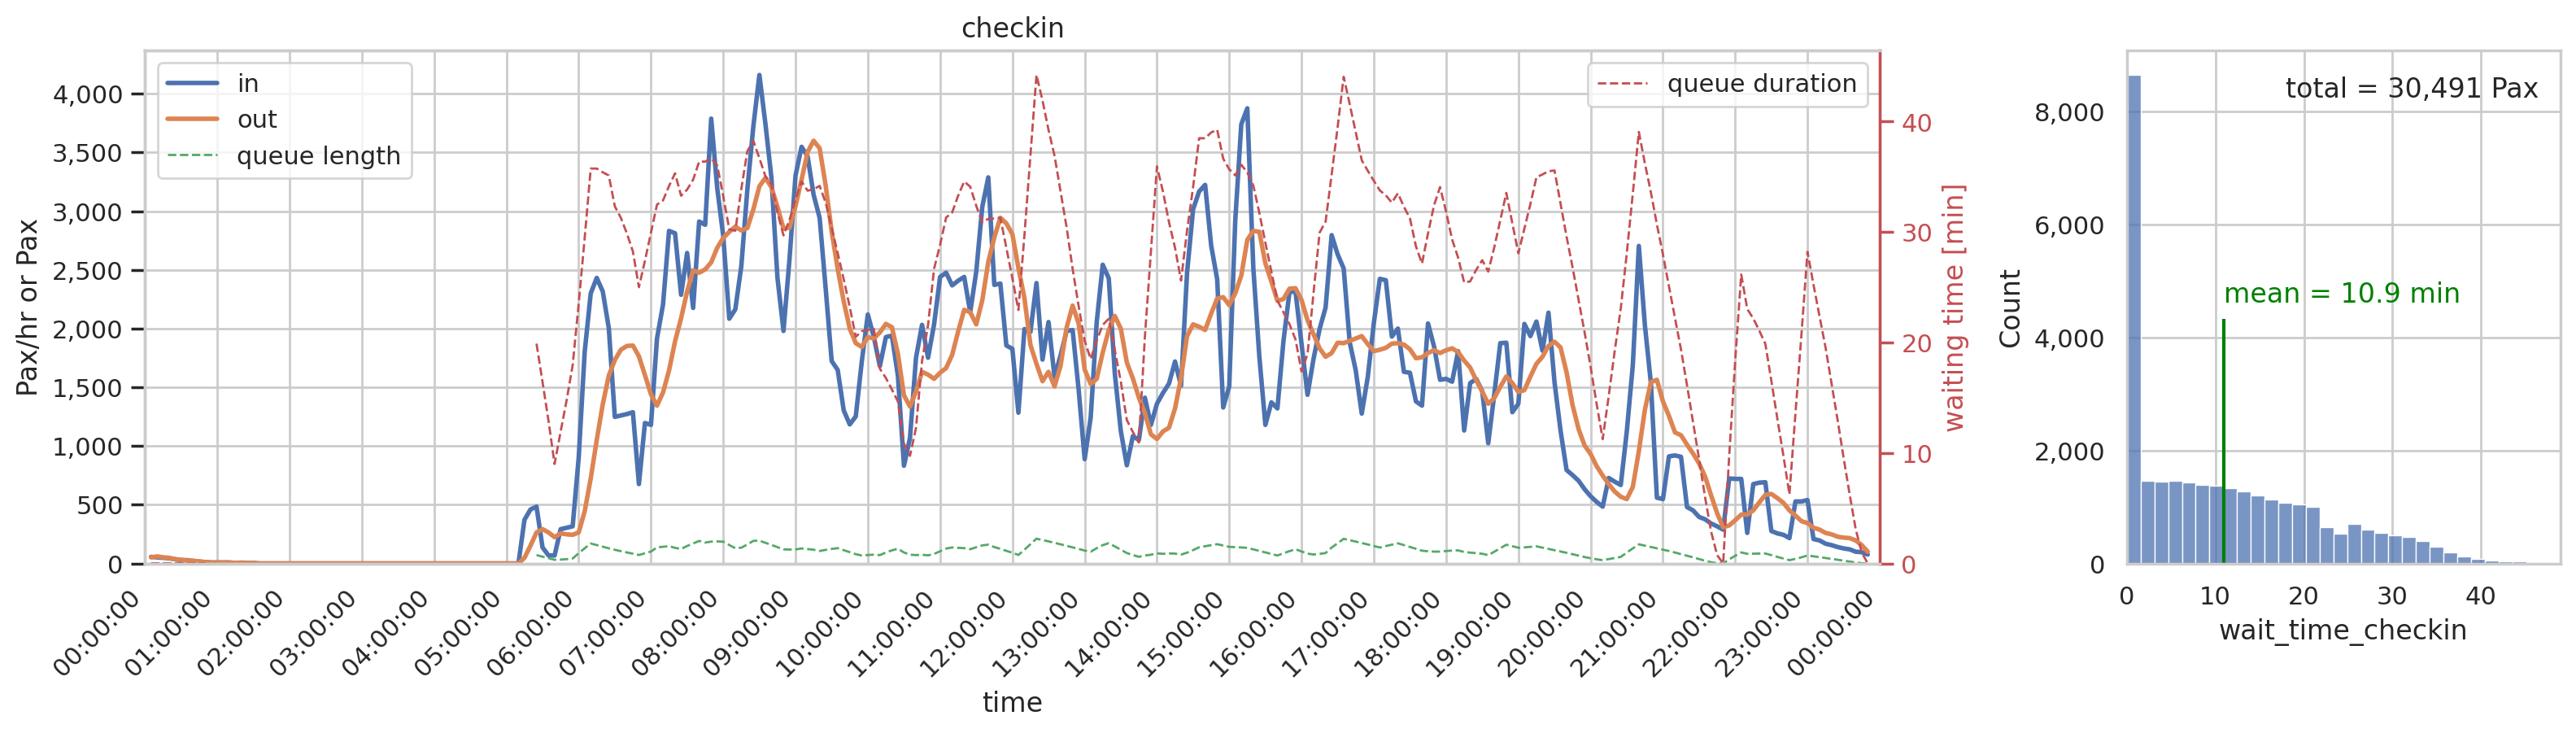

In [24]:
for key,simulation in simulations.items():
    simulation.plot_result()